<a href="https://colab.research.google.com/github/AlecTraas/computational-geo-lab/blob/main/Colab/Kai/hyperbolic_convex_hull.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import numpy as np
import matplotlib.pyplot as plt

In [65]:
# plots a geodesic segment through complex numbers a and b, with color c
def plot_geodesic(a,b,c):
    if abs(a.real - b.real) <= 2/900:
      plt.plot([a.real,b.real],[a.imag,b.imag],color=c)
      return
    o = ((a.real**2 + a.imag**2 - b.real**2 - b.imag**2) / (2*(a.real - b.real)), 0)
    x = np.linspace(min(a.real,b.real), max(a.real,b.real), 1000)
    arc = lambda x: np.sqrt(np.linalg.norm(np.array([a.real,a.imag]) - np.array(o))**2 - (x - o[0])**2) + o[1]
    y = [arc(xi) for xi in x]
    plt.plot(x,y,color=c)

In [66]:
# plots a list of points p, with color c
def plot_point(p,c):
    plt.scatter(np.real(p), np.imag(p), s=50, c=c, alpha=0.5)

In [67]:
# returns the distance between two points a and b
def dist(a,b):
  numer = np.abs(a - np.conjugate(b)) + np.abs(a - b)
  denom = np.abs(a - np.conjugate(b)) - np.abs(a - b)
  return np.log(numer/denom)

In [68]:
# returns the angle ∠ACB given points a, b, c
def angle(pa,pb,pc):
  a = dist(pb,pc)
  b = dist(pa,pc)
  c = dist(pa,pb)
  numer = np.cosh(a) * np.cosh(b) - np.cosh(c)
  denom = np.sinh(a) * np.sinh(b)
  return np.arccos(numer/denom)

In [72]:
# applies the inverse Cayley transform to a set of points z in the upper half plane
def inverse_cayley(w):
  return 1j * (1 + w) / (1 - w)

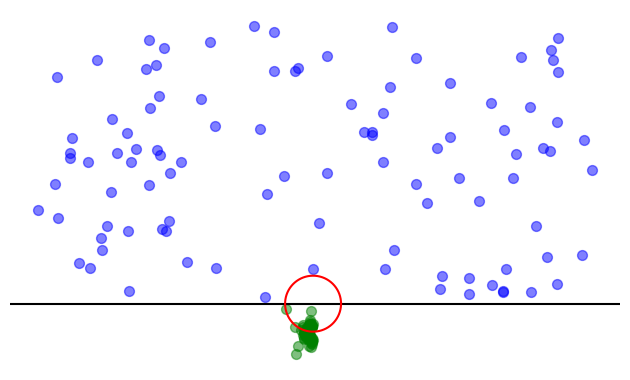

In [73]:
n = 100
points = np.random.uniform(-10, 10, n) + np.random.uniform(0, 10, n) * 1j


fig, ax = plt.subplots()
ax.axhline(0, color='black')

# this is what confuses me...
plot_point(inverse_cayley(points),'g')

plot_point(points,'b')

# unit circle
theta = np.linspace(0, 2*np.pi, 1000)
x = np.cos(theta)
y = np.sin(theta)
plt.plot(x, y, color = 'r')

# formatting
ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()